In [1]:
import soundfile
import librosa
import os
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
train_path = os.path.join('data', 'train')
human_path = os.path.join(train_path, 'human')
spoof_path = os.path.join(train_path, 'spoof')

In [15]:
print(len(os.listdir(human_path)), len(os.listdir(spoof_path)))

10322 39678


In [4]:
# "clean_audio, framerate = soundfile.read('audio_samples/' + '20-205-0000.flac')\n",
#     "noisy_audio, framerate = soundfile.read('audio_samples/' + '20-205-0000_noisy.wav')"
#     "# normalized log-mel-spectrogram of clean and noisy audios\n",
#     "clean_mel = 1 + np.log(1.e-12 + librosa.feature.melspectrogram(clean_audio, sr=16000, n_fft=1024, hop_length=256, fmin=20, fmax=8000, n_mels=80)).T / 10.\n",
#     "noisy_mel = 1 + np.log(1.e-12 + librosa.feature.melspectrogram(noisy_audio, sr=16000, n_fft=1024, hop_length=256, fmin=20, fmax=8000, n_mels=80)).T / 10."


In [44]:
human_audio, framerate = soundfile.read(os.path.join(human_path, os.listdir(human_path)[0]))
spoof_audio, framerate = soundfile.read(os.path.join(spoof_path, os.listdir(spoof_path)[0]))

In [37]:
h, sr = librosa.load(os.path.join(spoof_path, os.listdir(spoof_path)[0]))
mel = librosa.feature.melspectrogram(y=h, sr=sr, n_fft=1024, hop_length=256, fmin=20, fmax=8000, n_mels=80)

In [38]:
print(mel.shape)
print(sound_to_mel(h).shape)

(80, 391)
(391, 80)


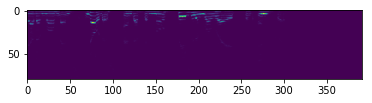

In [41]:
plt.imshow(mel)

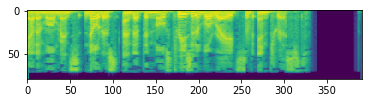

In [39]:
plt.imshow(sound_to_mel(h).T)

In [45]:
human_mel = 1 + np.log(1.e-12 + librosa.feature.melspectrogram(human_audio, sr=16000, n_fft=1024, hop_length=256, fmin=20, fmax=8000, n_mels=100)).T / 10.
spoof_mel = 1 + np.log(1.e-12 + librosa.feature.melspectrogram(spoof_audio, sr=16000, n_fft=1024, hop_length=256, fmin=20, fmax=8000, n_mels=100)).T / 10.

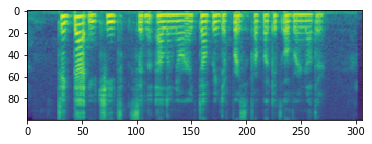

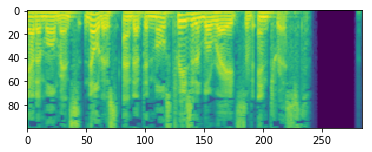

In [46]:
plt.imshow(human_mel.T)
plt.show()
plt.imshow(spoof_mel.T)

In [8]:
print(human_mel.shape, spoof_mel.shape)

(306, 100) (284, 100)


In [3]:
import os
import numpy as np
def filename_loader(path, size=None, balanced=True):
    spoof_dir = os.path.join(path, 'spoof')
    human_dir = os.path.join(path, 'human')
    spoof_files, human_files = [], []
    sp_lst = os.listdir(spoof_dir)
    hu_lst = os.listdir(human_dir)
    if balanced:
        max_len = min(len(sp_lst), len(hu_lst))
        spoof_idx = np.array(range(len(sp_lst)))
        human_idx = np.array(range(len(hu_lst)))
        np.random.shuffle(spoof_idx)
        np.random.shuffle(human_idx)
        spoof_files = [os.path.join(spoof_dir, sp_lst[idx]) for idx in spoof_idx[:max_len]]
        human_files = [os.path.join(human_dir, hu_lst[idx]) for idx in human_idx[:max_len]]
    else:
        spoof_files = [os.path.join(spoof_dir, filename) for filename in sp_lst]
        human_files = [os.path.join(human_dir, filename) for filename in hu_lst]
    files = np.concatenate((spoof_files, human_files))
    labels = np.concatenate((np.array([1] * len(spoof_files)), np.zeros(len(human_files))))
    idx = np.array(range(len(files)))
    np.random.shuffle(idx)
    if size == None:
        size = len(files)
    return [files[idx[i]] for i in range(len(idx[:size]))], [labels[idx[i]] for i in range(len(idx[:size]))]

In [5]:
x, y = filename_loader(train_path, balanced=False)

In [6]:
np.mean(y)

0.79356

In [7]:
x[14], y[14]

('data\\train\\spoof\\spoof_37055.wav', 1.0)

In [12]:
import pandas as pd
df = pd.DataFrame({'path' : x[:200], 's': y[:200]})
df.to_csv('protocol_test.txt', header=False, sep=' ', index=False)

(array([0., 1.]), array([10322, 39678], dtype=int64))


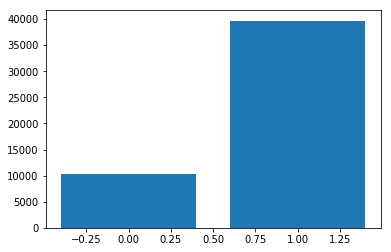

In [23]:
value_counts = np.unique(y, return_counts=True)
plt.bar(value_counts[0], value_counts[1])
print(value_counts)

In [4]:
import librosa
import numpy as np

def sound_to_mel(sound):
    """Convert Sound to MEL-Spectogram"""
    return 1 + np.log(1.e-12 + librosa.feature.melspectrogram(sound[0], sr=sound[1], n_fft=1024, hop_length=256, fmin=20, fmax=8000, n_mels=80)).T / 10.


def dataloader(path, size=None, reshape=True):
    files, labels = filename_loader(path, size)
    assert len(files) == len(labels), 'len(labels) should be equal to len(files)'
    if reshape:
        return np.array([reshape_mel(sound_to_mel(librosa.load(file))) for file in files]), np.array(labels)
    else:
        return np.array([sound_to_mel(librosa.load(file)) for file in files]), np.array(labels)

def reshape_mel(mel, shape=(80, 80)):
    """Reshape MEL-spectogram Using Simple Method Pad/Trim"""
    if mel.shape[0] > shape[0]:
        diff = mel.shape[0] - shape[0]
        offset = np.random.randint(diff)
        mel = mel[offset:shape[0] + offset, :]
    elif mel.shape[0] < shape[0]:
        diff = shape[0] - mel.shape[0]
        offset = np.random.randint(diff)
        mel = np.pad(mel, ((offset, shape[0] - mel.shape[0] - offset), (0, 0)), "reflect")
    if mel.shape[1] > shape[1]:
        diff = mel.shape[1] - shape[1]
        offset = np.random.randint(diff)
        mel = mel[:, offset:shape[1] + offset]
    elif mel.shape[1] < shape[1]:
        diff = shape[1] - mel.shape[1]
        offset = np.random.randint(diff)
        mel = np.pad(mel, ((0, 0), (offset, shape[1] - mel.shape[1] - offset)), "reflect")
    return mel

In [25]:
x, y = dataloader(train_path, size=20000, reshape=False)

<Container object of 255 artists>

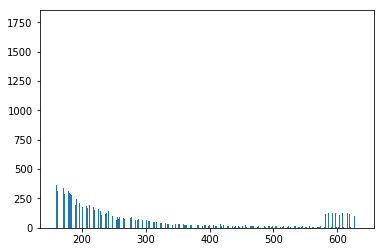

In [26]:
shapes = np.unique([mel.shape[0] for mel in x], return_counts=True)
plt.bar(shapes[0], shapes[1])

In [5]:
all_data, all_labels = dataloader(train_path)

In [6]:
np.save(os.path.join('data', 'train.npy'), all_data)
np.save(os.path.join('data', 'labels.npy'), all_labels)

In [7]:
all_data.shape

(20644, 80, 80)

In [1]:
import numpy as np
import os
def batch_iterator(path, batch_size=256, shuffle=False):
    data = np.load(os.path.join(path, 'train.npy'))
    labels = np.load(os.path.join(path, 'labels.npy'))
    idx = np.array(range(len(data)))
    if shuffle:
        np.random.shuffle(idx)
    for i in range(0, len(idx), batch_size):
        x = np.stack([data[idx[j]][None] for j in range(i, min(i + batch_size, len(data)))], 0)
        y = np.stack([labels[idx[j]][None] for j in range(i, min(i + batch_size, len(data)))], 0)
        yield x, y

In [2]:
import torch


class SpoofDetector(torch.nn.Module):
    """Spoof Detector Convolutional Neural network"""
    def __init__(self):
        super(SpoofDetector, self).__init__()
        input_shape = (80, 80)
        self.input_shape = input_shape
        self.conv = torch.nn.Sequential(torch.nn.Conv2d(1, 10, kernel_size=3, stride=1, padding=1),
                                        torch.nn.ReLU(),
                                        torch.nn.MaxPool2d(kernel_size=2, padding=0, stride=1),
                                        torch.nn.Conv2d(10,15, kernel_size=3, stride=1, padding=1),
                                        torch.nn.ReLU(),
                                        torch.nn.MaxPool2d(kernel_size=2, padding=0, stride=1),
                                        torch.nn.Conv2d(15, 20, kernel_size=3, stride=1, padding=1),
                                        torch.nn.ReLU(),
                                        torch.nn.MaxPool2d(kernel_size=2, padding=0, stride=1),
                                        torch.nn.Conv2d(20, 30, kernel_size=3, padding=1, stride=1),
                                        torch.nn.LeakyReLU(),
                                        torch.nn.MaxPool2d(kernel_size=2, padding=0, stride=1))
        self.linsize = (self.input_shape[0] - 4) * (self.input_shape[1] - 4)
        self.fc = torch.nn.Sequential(torch.nn.Linear(30 * self.linsize, 20),
                                     torch.nn.Dropout(0.5),
                                     torch.nn.Linear(20, 1),
                                     torch.nn.Sigmoid())

    def forward(self, input):
        out = self.conv(input)
        out = out.view(-1, 30 * self.linsize)
        out = self.fc(out)
        return out


In [3]:
import torch
from torch.autograd import Variable
from torch.optim import Adam
import sys
import os
from tqdm import tqdm
import time

def train(net, path, batch_size=128, n_epochs=30, lr=1e-3):
    optimizer = Adam(net.parameters(), lr=lr)
    loss = torch.nn.BCELoss()
    for i in tqdm(range(n_epochs), desc='Training epochs'):
        sum_loss = 0
        for x, y in batch_iterator(path, batch_size=batch_size):
            x = Variable(torch.Tensor(x)).cuda()
            y = Variable(torch.Tensor(y)).cuda()
            optimizer.zero_grad()
            output = net(x)
            loss_out = loss(output, y)
            loss_out.backward()
            optimizer.step()
            sum_loss += loss_out.data[0]
        if i % 5 == 0 and i > 0:
            print("EPOCH #" + str(i))
            print("Loss: " + str(sum_loss))
            if i % 10 == 0:
                torch.save(net, 'trained/cnn_epoch' + str(i) + '.pth')
    torch.save(net, 'trained/cnn.pth')

In [4]:
model = SpoofDetector().cuda()
train(model, 'data')

Training epochs:  17%|███████████                                                       | 5/30 [04:58<24:52, 59.72s/it]

EPOCH #5
Loss: 36.188279047608376


Training epochs:  33%|█████████████████████▋                                           | 10/30 [09:55<19:49, 59.48s/it]

EPOCH #10
Loss: 19.996141489595175


C:\Users\mi\Anaconda3\lib\site-packages\torch\serialization.py:159: UserWarning: Couldn't retrieve source code for container of type SpoofDetector. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
Training epochs:  50%|████████████████████████████████▌                                | 15/30 [14:53<14:51, 59.45s/it]

EPOCH #15
Loss: 14.401243556290865


Training epochs:  67%|███████████████████████████████████████████▎                     | 20/30 [19:49<09:53, 59.34s/it]

EPOCH #20
Loss: 6.920521414605901


Training epochs:  83%|██████████████████████████████████████████████████████▏          | 25/30 [24:46<04:56, 59.33s/it]

EPOCH #25
Loss: 4.497983856126666


Training epochs: 100%|█████████████████████████████████████████████████████████████████| 30/30 [29:41<00:00, 59.03s/it]


In [17]:
from sklearn.metrics import accuracy_score
import torch
import numpy as np
from torch.autograd import Variable
import sys
import os

def validate(model_path=os.path.join('trained', 'cnn.pth')):
    model = torch.load(model_path).cpu()
    predicted = np.array([])
    labels = np.array([])
    for x, y in batch_iterator('data', batch_size=1000):
        x = Variable(torch.Tensor(x))
        x = np.array(list(map(lambda val: 1 if val >= 0.5 else 0, model(x).data.numpy())))
        predicted = np.concatenate((predicted, x))
        print(labels.shape, y.shape)
        labels = np.concatenate((labels, y.reshape(-1)))
        print(accuracy_score(labels, predicted))
    return accuracy_score(labels, predicted)


In [ ]:
# Script.py

import librosa
def loadmel(wav_path):
        return reshape_mel(sound_to_mel(librosa.load(wav_path)))[None]

model = torch.load(os.path.join('trained', 'cnn.pth')).cuda()


dataset_dir = "."
eval_protocol_path = "protocol_test.txt"
eval_protocol = pd.read_csv(eval_protocol_path, sep=" ", header=None)
eval_protocol.columns = ['path', 'key']
eval_protocol['score'] = 0.0

print(eval_protocol.shape)
print(eval_protocol.sample(5).head())

for protocol_id, protocol_row in tqdm.tqdm(list(eval_protocol.iterrows())):
    feature = dev_get_feature(os.path.join(dataset_dir, protocol_row['path']))[np.newaxis, ..., np.newaxis]
    mel = loadmel(os.path.join(dataset_dir, protocol_row['path']))
    mel = Variable(torch.Tensor(mel))
    score = model(mel).data.numpy()
    eval_protocol.at[protocol_id, 'score'] = score[0][0]
eval_protocol[['path', 'score']].to_csv('answers.csv', index=None)
print(eval_protocol.sample(5).head())


In [1]:
import utils

In [2]:
import torch

In [3]:
model = torch.load('trained/cnn.pth')

In [4]:
torch.save(model.state_dict(), 'model.dat')

In [5]:
model = utils.SpoofDetector()

In [7]:
model.load_state_dict(torch.load('model.dat'))

In [1]:
!pip install scikit-learn --upgrade

  Using cached https://files.pythonhosted.org/packages/a9/bc/18663f6d75838b73353ba49fabd631347e68470ec9e623d7b3f3ccd4f426/scikit_learn-0.21.2-cp36-cp36m-win_amd64.whl
  Found existing installation: scikit-learn 0.19.1
    Uninstalling scikit-learn-0.19.1:
      Successfully uninstalled scikit-learn-0.19.1


In [2]:
import sklearn
sklearn.__version__

'0.21.2'